In [186]:
using CRCBS
using Distributions
using HCubature
using Plots
using Combinatorics

In [7]:
function integrate_node_with_box_nb(n1,t1,n2,t2,nn,lambda,dtcount;bound_radius=10.0)
    function h(x)
        y = x[1]
        t = x[2]
        density = (1-cdf(Gamma(nn,lambda),abs(t2-t1-y))) * pdf(Gamma(n1,lambda), t) * pdf(Gamma(n2,lambda),t-y)
        return density
    end

    tmax = (-n1*n2 + n1 + n2 - 1)*lambda/(1-n1)
    ymax = tmax - (n1-1)*lambda

    yleft = min(ymax,t1-t2)
    yright = max(ymax,t1-t2)

    tleft = max(0,min(tmax,t1-t2+(n1-1)/lambda))
    tright=max(0,max(tmax,t1-t2+(n1-1)/lambda))

    left = [yleft-bound_radius,max(tleft-bound_radius,0)]
    right = [yright + bound_radius, tright+bound_radius]

    res1 = @timed(hcubature(h,left,right,maxevals=10^8))
    C,err = res1[1]
    dtint = res1[2] #time spent performing integration

    return C, err, dtint + dtcount
end

integrate_node_with_box_nb (generic function with 1 method)

In [211]:
function rand_integer_part_sum(k,n;limit=0)
    """Random integer partition of k integers summing to n"""
    random_limit_breach = rand(1:limit+1)-1
    list = integer_partitions(n+random_limit_breach)
    
    list_k = Vector{}()
    for elt in list
        if length(elt) == k
            r = random_limit_breach
            while r > 0
                unlucky = rand(1:k)
                elt[unlucky] -= 1
                r -= 1
            end
            push!(list_k,elt)
        end
    end
    return rand(list_k)
end

rand_integer_part_sum (generic function with 1 method)

In [212]:
function rand_integer_part(k,n;limit=10)
    """Random integer partition of k integers summing to n in absolute value"""
    list = integer_partitions(n+k) 
    list_k = Vector{}()
    for elt in list
        elt = elt .- 1.0
        if length(elt) == k
            unlucky_idxs = rand(1:k,rand(1:Int64(round(k/2))))
            for idx in unlucky_idxs
                if abs(elt[idx]) < limit
                    elt[idx] *= -1
                end
            end
            push!(list_k,elt)
        end
    end
    return rand(list_k)
end

rand_integer_part (generic function with 1 method)

### Varying λ

In [22]:
n1 = 11
n2 = 12
t1 = 10.0
t2 = 8.0
nm = 5.0
dtcount = 0.0

lambdas = collect(range(0.05,stop=10.0,step=0.05));

In [23]:
probabilities = [integrate_node_with_box_nb(n1,t1,n2,t2,nm,lambda,dtcount)[1] for lambda in lambdas];

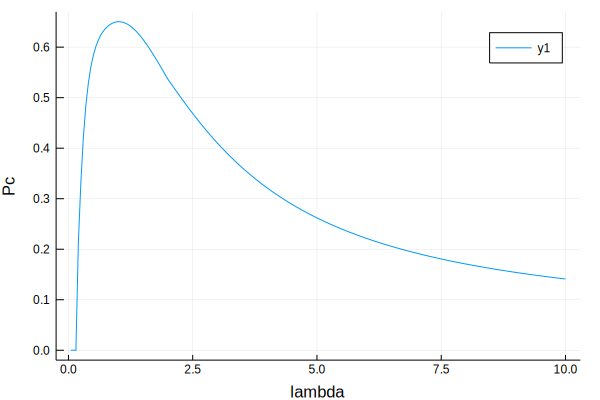

In [24]:
plot(lambdas,probabilities,xlabel="lambda",ylabel="Pc")

### Constant error on nm

In [19]:
n1 = 11
n2 = 12
t1 = 10.0
t2 = 8.0
lambda = 0.4
dtcount = 0.0

nm_error = collect(range(0,stop=10,step=1));

In [20]:
probabilities = [integrate_node_with_box_nb(n1*(1+nm),t1,n2*(1+nm),t2,5.0+nm,lambda,dtcount)[1] for nm in nm_error];

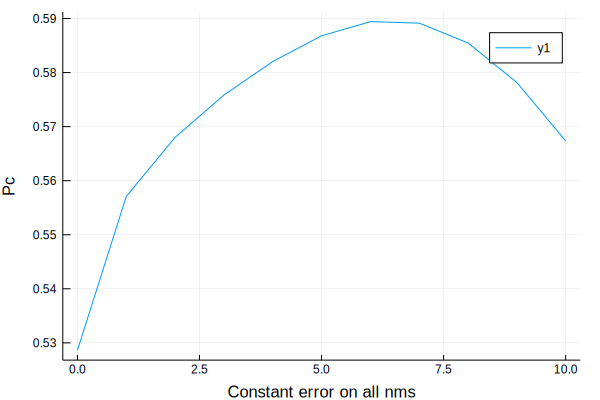

In [21]:
plot(nm_error,probabilities,xlabel="Constant error on all nms",ylabel="Pc")

### Varying nm only

In [223]:
n1 = 11
n2 = 15
t1 = 10.0
t2 = 8.0
nm = 11.0
lambda = 0.4
dtcount = 0.0

nm_error = collect(range(-10,stop=10,step=1));

In [224]:
probabilities = [integrate_node_with_box_nb(n1,t1,n2,t2,nm+nme,lambda,dtcount)[1] for nme in nm_error];

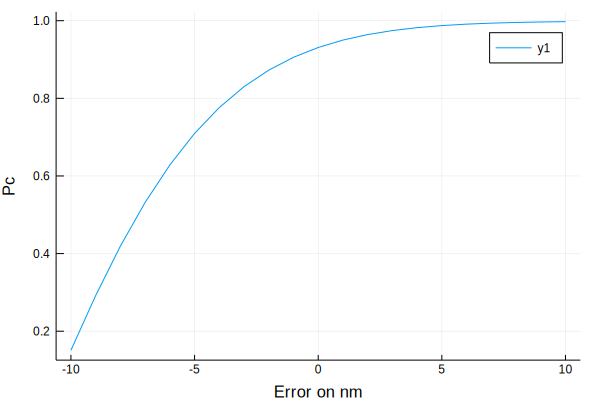

In [220]:
plot(nm_error,probabilities,xlabel="Error on nm",ylabel="Pc")

### Varying n1

In [169]:
n1 = 11
n2 = 15
t1 = 10.0
t2 = 8.0
lambda = 0.4
dtcount = 0.0

n1_error = collect(range(-10,stop=10,step=1));

In [170]:
probabilities = [integrate_node_with_box_nb(n1 + n1e,t1,n2,t2,nm,lambda,dtcount)[1] for n1e in n1_error];

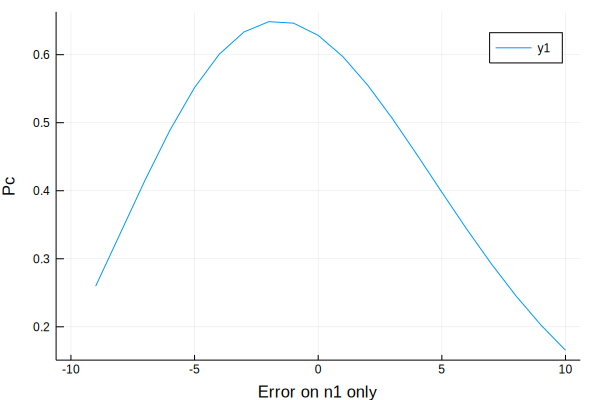

In [171]:
plot(n1_error,probabilities,xlabel="Error on n1 only",ylabel="Pc")

### Varying errors summing to k

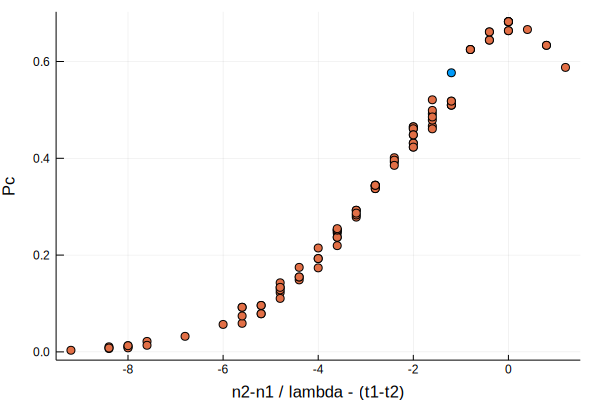

In [225]:
n1 = 11
n2 = 13
t1 = 10.0
t2 = 8.0
nm = 5.0
lambda = 0.4
dtcount = 0.0

errors = rand(1:20,100) #Errors sum to 1 -> errors sum to 20

plot(xlabel="n2-n1 / lambda - (t1-t2)",ylabel="Pc",leg=false)

for n in errors
    l = rand_integer_part(2,n;limit=4)
    probability = integrate_node_with_box_nb(n1+l[1],t1,n2+l[2],t2,nm,lambda,dtcount)[1]
    scatter!([(l[2]-l[1])*lambda + (n2-n1)*lambda - (t1-t2)],[probability],color=2)
end

# True value
scatter!([t2-t1 + (n2-n1)*lambda],[integrate_node_with_box_nb(n1,t1,n2,t2,nm,lambda,dtcount)[1]],color=1)

### Varying errors in a ball on all terms

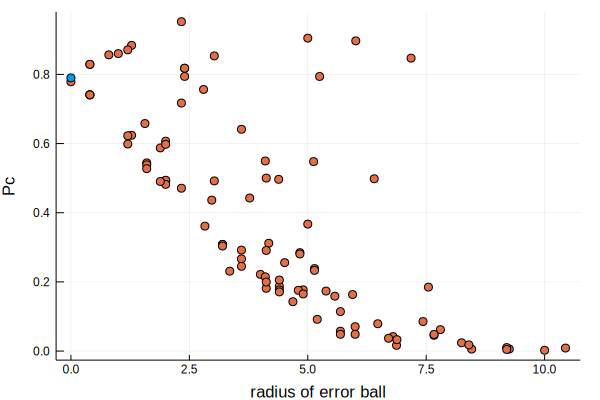

In [232]:
n1 = 11
n2 = 13
t1 = 10.0
t2 = 8.0
nm = 8.0
lambda = 0.4
dtcount = 0.0

errors = rand(1:30,100) #Errors sum to 1 -> errors sum to 20

plot(xlabel="radius of error ball",ylabel="Pc",leg=false)

for n in errors
    l = rand_integer_part(3,n;limit=6)
    probability = integrate_node_with_box_nb(n1+l[1],t1,n2+l[2],t2,nm+l[3],lambda,dtcount)[1]
    n2n1_sq = ((l[2]-l[1])*lambda)^2
    scatter!([sqrt(n2n1_sq + l[3]^2)],[probability],color=2)
end

# True value
scatter!([0],[integrate_node_with_box_nb(n1,t1,n2,t2,nm,lambda,dtcount)[1]],color=1)